# 示例：在Dynex上进行量子深度学习（使用scikit-learn）

这个示例展示了如何使用Dynex SDK的Scikit包，它提供了一个用于特征选择的scikit-learn转换器，利用了Dynex神经形态计算平台。特征的数量对神经网络的训练和准确性有影响。我们将演示如何显著减少特征数量会导致类似（甚至更好）的结果

In [1]:
import dynex
from dynex_scikit_plugin import dynex_scikit

## 数据集：威斯康星州乳腺癌数据

这些特征是从乳腺肿块的细针穿刺（FNA）图像的数字化图像中计算的。它们描述了图像中存在的细胞核的特征。

上面描述的分离平面是使用Multisurface Method-Tree（MSM-T）[K. P. Bennett，“通过线性规划构建决策树。”第4届中西部人工智能和认知科学协会会议论文集，1992年，第97-101页]获得的，这是一种使用线性规划构建决策树的分类方法。通过在1-4个特征和1-3个分离平面的空间中进行详尽搜索来选择相关特征。

用于在三维空间中获得分离平面的实际线性规划描述如下：
[K. P. Bennett和O. L. Mangasarian：“两个线性不可分集的稳健线性规划判别”，Optimization Methods and Software 1，1992，第23-34页]。

In [7]:
from sklearn.datasets import load_breast_cancer

In [8]:
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

In [9]:
X_cancer.shape

(569, 30)

# 深度神经网络

首先我们加载依赖

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Sklearn提供了多个激活函数。首先，我们可视化不同的函数：

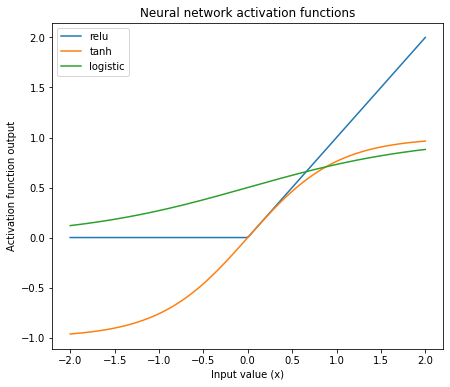

In [11]:
xrange = np.linspace(-2, 2, 200)
plt.figure(figsize=(7,6))
plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')
plt.show()

## 数据准备

我们需要将数据集分为训练和验证（测试）数据，并对数据进行缩放。

In [12]:
scaler = MinMaxScaler();
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Training Datapoints: ',len(X_train), 'Validation Datapoints:', len(X_test))
print('Features:', X_cancer.shape[1])

Training Datapoints:  426 Validation Datapoints: 143
Features: 30


原始的乳腺癌数据集具有30个特征

## 多层感知器分类器（MLP）

首先，我们构建了一个具有隐藏层（100, 100）的深度学习网络。我们将使用MPL分类器，其代表多层感知器分类器，这个名称本身就与神经网络有关。与其他分类算法（如支持向量机或朴素贝叶斯分类器）不同，MLPClassifier 依赖于底层的神经网络来执行分类任务。

## 使用Adam随机梯度下降优化器

第一种方法是使用“relu”激活函数，并应用默认的“adam”求解器进行模型训练

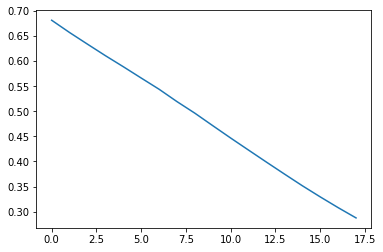

In [13]:
model = MLPClassifier(hidden_layer_sizes=(100, 100),
              activation='relu',
              solver='adam',
              learning_rate='adaptive',
              early_stopping=True)

model.fit(X_train_scaled, y_train)
prd_r = model.predict(X_test_scaled)
loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [14]:
print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(model.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(model.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.91
Accuracy of NN classifier on test set: 0.92


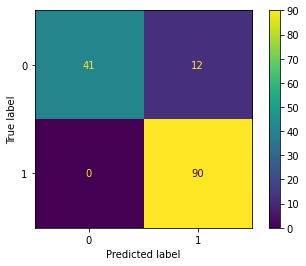

In [16]:
cm = confusion_matrix(y_test, prd_r)
cm_display = ConfusionMatrixDisplay(cm).plot()

可以看到，模型在测试集上的准确率约为92%，这是一个良好的开始。上面的混淆矩阵显示了模型在验证数据集上的预测与预期结果的比较。在这种情况下，模型错误地诊断了12例乳腺癌病例，相当于11.76% 的假阳性

# 使用'lbfgs'，这是拟牛顿方法家族中的一个优化器

Scikit-learn提供了更强大的多层感知器网络功能。我们将使用'lbfgs'，这是拟牛顿方法中的一个优化器：

In [17]:
clf = MLPClassifier(hidden_layer_sizes = [100, 100], 
                    alpha = 5.0,
                    random_state = 0, 
                    solver='lbfgs').fit(X_train_scaled, y_train) 

In [18]:
print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


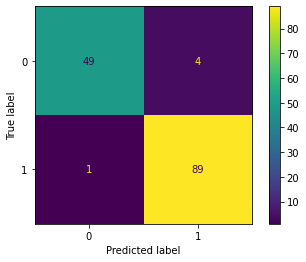

In [19]:
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

模型的准确率显著提高至97%，假阳性率为4.30%

## 使用Dynex SciKit插件来减少特征数量

我们可以运行一个用于特征选择的量子算法，以找出乳腺癌数据集的相关特征。这是通过调用Dynex Scikit-Learn插件 "SelectFromQuadraticModel" 来实现的，我们可以指定目标特征数。我们希望将特征的数量减少33%，仅保留20个特征：

In [20]:


X_new = dynex_scikit.SelectFromQuadraticModel(num_features=20).fit_transform(X_cancer, y_cancer)

[DYNEX|-1] 0.00s #workers: 1 #chips: 2048 #steps: 200 global falsified softs: 29 global energy: 1224325.0
[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET LOADED
Best energy: -58.511830232669524 feasible? True


变量 X_new 包含了经过 scikit-learn 转换的数据，现在有20个特征：

In [21]:
X_new.shape

(569, 20)

我们执行与上面相同的训练方法，但将乳腺癌数据集缩减为20个特征：

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

In [24]:
print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


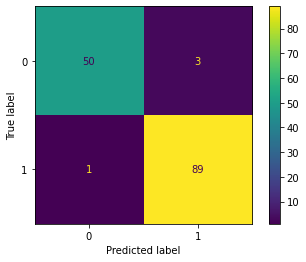

In [25]:
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

训练出的模型显示了较少的假阳性，尽管它只是使用原始数据集的三分之二特征进行训练，但准确度数值相似

参考文献:

[1] Milne, Andrew, Maxwell Rounds 和 Phil Goddard. 2017. "Optimal Feature Selection in Credit Scoring and Classification Using a Quantum Annealer." 1QBit；白皮书。链接：https://1qbit.com/whitepaper/optimal-feature-selection-in-credit-scoring-classification-using-quantum-annealer/